# **Práctica: Flujos de Datos en Clasificación, Concept Drift, Agrupamiento, Anomalías, Texto y Ensembles**


- Álvaro Alcalde Cid
- Felipe Guzmán Rodríguez
- Pablo Díaz-Masa Valencia

## **Conjunto de datos**

Este dataset proviene de Kaggle. En principio, sólo contenía dos campos: el texto de un SMS y una variable binaria que indica si es spam o no.
Hemos añadido diez variables más a partir del texto de cada mensaje. Mediante expresiones regulares, hemos contado características numéricas relevantes del mensaje y las hemos incluido para tareas posteriores.
    
Este conjunto de datos contiene 5574 registros y 12 columnas:

- spam: Etiqueta que indica si el mensaje es spam (1) o no (0)
- text: El contenido del mensaje de texto
- num_caracteres: Número total de caracteres en el mensaje
- num_palabras: Cantidad de palabras
- num_alfabeticos: Número de caracteres alfabéticos
- num_numericos: Número de caracteres numéricos
- num_no_alfanum: Cantidad de caracteres no alfanuméricos (%, &, #, $, ;, etc.)
- num_divisas: Número de símbolos de divisas ($, €, £, etc.)
- num_mayusculas: Número de caracteres en mayúscula
- num_exclamaciones: Número de signos de exclamación
- num_interrogaciones: Número de signos de interrogación
- num_urls: Cantidad de URLs presentes en el mensaje
    
Este conjunto de datos ofrece información útil y tiene la forma idónea para los objetivos de esta práctica.

-------------

## **Carga de Datos**

Cargamos el dataset que contiene los SMS con sus características extraídas y una columna que indica si es SPAM o no.

In [1]:
import pandas as pd

# Cargar los datos
df = pd.read_csv('spam_SMS_ampliado.csv')
df.columns

Index(['spam', 'text', 'num_caracteres', 'num_palabras', 'num_alfabeticos',
       'num_numericos', 'num_no_alfanum', 'num_divisas', 'num_mayusculas',
       'num_exclamaciones', 'num_interrogaciones', 'num_urls'],
      dtype='object')

In [2]:
df.head(5)

,spam,text,num_caracteres,num_palabras,num_alfabeticos,num_numericos,num_no_alfanum,num_divisas,num_mayusculas,num_exclamaciones,num_interrogaciones,num_urls
0,0,"Go until jurong point, crazy.. Available only ...",111,20,83,0,28,0,3,0,0,0
1,0,Ok lar... Joking wif u oni...,29,6,18,0,11,0,2,0,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,97,25,33,0,10,0,0,0
3,0,U dun say so early hor... U c already then say...,49,11,33,0,16,0,2,0,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,47,0,14,0,2,0,0,0


In [3]:
len(df)

5574

------------

## **Clasificación**

Vamos a entrenar y evaluar varios clasificadores en flujo de datos:

- Árbol Hoeffding (HoeffdingTreeClassifier).
- Árbol Adaptativo Hoeffding (HoeffdingAdaptiveTreeClassifier).
- Árbol de Decisión Extremadamente Rápido (ExtremelyFastDecisionTreeClassifier).

Estos modelos se basan en árboles de decisión, empleando el teorema de Hoeffding para tomar decisiones con una cantidad mínima de datos, lo que los hace eficientes en entornos de flujo continuo. Hemos seleccionado el HoeffdingTreeClassifier como modelo base, ya que se espera que funcione bien con un flujo de datos estable, permitiendo realizar clasificaciones precisas con un bajo coste computacional.

El HoeffdingAdaptiveTreeClassifier, en cambio, tiene la capacidad de adaptarse a cambios en los patrones de datos (concept drift). A pesar de que creemos que nuestros datos son relativamente estables, es posible que se produzcan pequeñas variaciones con el tiempo. Por lo tanto, evaluar este clasificador nos permitirá comprobar si, efectivamente, su capacidad de adaptación mejora la precisión en caso de que surjan desviaciones sutiles.

Finalmente, hemos decidido incluir el ExtremelyFastDecisionTreeClassifier para comparar su eficiencia y rendimiento frente a los otros modelos. Este clasificador optimiza la construcción del árbol, lo que puede resultar en tiempos de procesamiento más rápidos. Sin embargo, es importante evaluar si esta velocidad compromete la precisión en comparación con un modelo más estable.

La métrica de evaluación que utilizaremos para cada modelo será la F1 Score, ya que nos interesa balancear la precisión y la sensibilidad.

In [4]:
from river import tree, metrics

model_standard = tree.HoeffdingTreeClassifier()

metric = metrics.F1()

for index, row in df.iterrows():
    x = {
            'num_caracteres': row['num_caracteres'],
            'num_palabras': row['num_palabras'],
            'num_alfabeticos': row['num_alfabeticos'],
            'num_numericos': row['num_numericos'],
            'num_no_alfanum': row['num_no_alfanum'],
            'num_divisas': row['num_divisas'],
            'num_mayusculas': row['num_mayusculas'],
            'num_exclamaciones': row['num_exclamaciones'],
            'num_interrogaciones': row['num_interrogaciones'],
            'num_urls': row['num_urls']
        }

    y = row['spam'] 
    y_pred = model_standard.predict_one(x)
    model_standard.learn_one(x, y)
    metric.update(y, y_pred)
    
print(f'F1 Score para HoeffdingTreeClassifier: {metric}')

F1 Score para HoeffdingTreeClassifier: F1: 86.65%


In [38]:
model_adaptive = tree.HoeffdingAdaptiveTreeClassifier()

metric = metrics.F1()

for index, row in df.iterrows():
    x = {
            'num_caracteres': row['num_caracteres'],
            'num_palabras': row['num_palabras'],
            'num_alfabeticos': row['num_alfabeticos'],
            'num_numericos': row['num_numericos'],
            'num_no_alfanum': row['num_no_alfanum'],
            'num_divisas': row['num_divisas'],
            'num_mayusculas': row['num_mayusculas'],
            'num_exclamaciones': row['num_exclamaciones'],
            'num_interrogaciones': row['num_interrogaciones'],
            'num_urls': row['num_urls']
        }

    y = row['spam'] 
    y_pred = model_adaptive.predict_one(x)
    model_adaptive.learn_one(x, y)
    metric.update(y, y_pred)
    
print(f'F1 Score para HoeffdingAdaptiveTreeClassifier: {metric}')

F1 Score para HoeffdingAdaptiveTreeClassifier: F1: 86.68%


In [6]:
model_extreme = tree.ExtremelyFastDecisionTreeClassifier(grace_period=120)

metric = metrics.F1()

for index, row in df.iterrows():
    x = {
            'num_caracteres': row['num_caracteres'],
            'num_palabras': row['num_palabras'],
            'num_alfabeticos': row['num_alfabeticos'],
            'num_numericos': row['num_numericos'],
            'num_no_alfanum': row['num_no_alfanum'],
            'num_divisas': row['num_divisas'],
            'num_mayusculas': row['num_mayusculas'],
            'num_exclamaciones': row['num_exclamaciones'],
            'num_interrogaciones': row['num_interrogaciones'],
            'num_urls': row['num_urls']
        }
    
    y = row['spam'] 
    y_pred = model_extreme.predict_one(x)
    model_extreme.learn_one(x, y)
    metric.update(y, y_pred)

print(f'F1 Score para ExtremelyFastDecisionTreeClassifier: {metric}')

F1 Score para ExtremelyFastDecisionTreeClassifier: F1: 86.16%


### **Observaciones:**
Las conclusiones obtenidas a partir de las pruebas con los clasificadores online muestran resultados consistentes con lo esperado. El ExtremelyFastDecisionTreeClassifier obtuvo un F1-Score de 86.16%, ligeramente inferior a los otros modelos. Esta pequeña disminución indica que, aunque este clasificador está optimizado para mayor velocidad, la precisión se ve mínimamente afectada. Aun así, debido a la leve diferencia, se podría considerar una opción adecuada en implementaciones en tiempo real, especialmente en contextos donde es fundamental una respuesta rápida, como es este, la detección de spam en SMS.

Por otro lado, el HoeffdingAdaptiveTreeClassifier mostró un F1-Score de 86.85%, superando al HoeffdingTreeClassifier, que alcanzó un 86.65%. Esta mejora, aunque pequeña, demuestra que la capacidad del árbol adaptativo para ajustarse a cambios en los patrones de datos (concept drift) le permite obtener un rendimiento ligeramente superior. Esto lo convierte en una buena elección cuando existe la posibilidad de que las características del flujo de datos varíen.

En resumen, las diferencias observadas en los resultados son mínimas, lo cual permite cierta flexibilidad a la hora de elegir el clasificador, dependiendo de si se prioriza la velocidad o la precisión en un entorno de flujo de datos.

------------

## **Detección de Concept Drift**

Después de haber clasificado los datos y observar cómo el HoeffdingAdaptiveTreeClassifier se adapta eficazmente al concept drift, mejorando sus predicciones en comparación con el árbol estándar, procederemos a la detección de dicho concept drift. Para ello, utilizaremos distintos detectores que monitorean tanto cambios en los datos (data drift) como en el rendimiento del modelo (model drift):

- **KSWIN (KSWIN)**: Un detector de cambios basado en ventanas deslizantes, que permite identificar cambios en la distribución de los datos en tiempo real.
- **EDDM (EDDM)**: Un monitor que analiza la desviación en los errores esperados, especializado en detectar cambios graduales en la distribución.
- **DDM (DDM)**: Un monitor que detecta desviaciones en los errores de detección, útil para identificar cambios repentinos en el flujo de datos.

Aplicaremos estos detectores sobre los tres modelos iniciales:

1. HoeffdingTreeClassifier
2. HoeffdingAdaptiveTreeClassifier
3. ExtremelyFastDecisionTreeClassifier

El objetivo de probar estos detectores en los tres modelos es comparar la frecuencia de detección de cambios entre el modelo estándar y el extremadamente rápido frente al adaptativo. Anticipamos que el modelo adaptativo debería detectar menos cambios, ya que, al ajustarse continuamente durante la clasificación, se espera que mitigue la aparición de concept drift de forma proactiva.

### **Concept Drift en HoeffdingTreeClassifier**

Entrenaremos un modelo estándar de árbol Hoeffding y usaremos los detectores de concept drift para evaluar si se detectan cambios en los datos durante el flujo.

In [7]:
from river import tree, metrics, drift
import river
print(river.__version__)

model_standard = tree.HoeffdingTreeClassifier()

metric = metrics.F1()

kswin = drift.KSWIN()
eddm = drift.binary.EDDM()
ddm = drift.binary.DDM()

total_eddm = 0
total_ddm = 0
total_kswin = 0

for index, row in df.iterrows():
    x = {
        'num_caracteres': row['num_caracteres'],
        'num_palabras': row['num_palabras'],
        'num_alfabeticos': row['num_alfabeticos'],
        'num_numericos': row['num_numericos'],
        'num_no_alfanum': row['num_no_alfanum'],
        'num_divisas': row['num_divisas'],
        'num_mayusculas': row['num_mayusculas'],
        'num_exclamaciones': row['num_exclamaciones'],
        'num_interrogaciones': row['num_interrogaciones'],
        'num_urls': row['num_urls']
    }

    y = row['spam'] 
    y_pred = model_standard.predict_one(x)
    model_standard.learn_one(x, y)
    metric.update(y, y_pred)
    
    eddm.update(int(y == y_pred))
    ddm.update(int(y == y_pred))
    kswin.update(int((x['num_mayusculas'])))
    
    if eddm.drift_detected: 
        print(f"EDDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_eddm += 1
    if ddm.drift_detected:
        print(f"DDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_ddm += 1
    if kswin.drift_detected:
        print(f"KSWIN - Data drift detectado en el ejemplo {index} ({metric})")
        total_kswin += 1

print('---------------------------------------------------')
print(f'Resultado final (HoeffdingTreeClassifier): {metric}')
print(f'Total de drifts detectados por EDDM: {total_eddm}')
print(f'Total de drifts detectados por DDM: {total_ddm}')
print(f'Total de drifts detectados por KSWIN: {total_kswin}')

0.21.2
EDDM - Model drift detectado en el ejemplo 48 (F1: 14.29%)
EDDM - Model drift detectado en el ejemplo 111 (F1: 16.00%)
EDDM - Model drift detectado en el ejemplo 174 (F1: 53.57%)
EDDM - Model drift detectado en el ejemplo 224 (F1: 52.46%)
EDDM - Model drift detectado en el ejemplo 297 (F1: 59.26%)
EDDM - Model drift detectado en el ejemplo 389 (F1: 68.47%)
DDM - Model drift detectado en el ejemplo 440 (F1: 71.43%)
EDDM - Model drift detectado en el ejemplo 478 (F1: 73.13%)
EDDM - Model drift detectado en el ejemplo 557 (F1: 75.64%)
KSWIN - Data drift detectado en el ejemplo 3318 (F1: 85.91%)
KSWIN - Data drift detectado en el ejemplo 3490 (F1: 85.99%)
KSWIN - Data drift detectado en el ejemplo 4619 (F1: 86.31%)
---------------------------------------------------
Resultado final (HoeffdingTreeClassifier): F1: 86.65%
Total de drifts detectados por EDDM: 8
Total de drifts detectados por DDM: 1
Total de drifts detectados por KSWIN: 3


### **Concept Drift en HoeffdingAdaptiveTreeClassifier**

Ahora, vamos a implementar el árbol adaptativo Hoeffding, que puede adaptarse a los cambios detectados en el concepto de los datos, y lo evaluamos con los detectores de drift.

In [8]:
# crear, entrenar y evaluar modelo
model_adaptive = tree.HoeffdingAdaptiveTreeClassifier()

metric = metrics.F1()

# detectores de drift
kswin = drift.KSWIN()
eddm = drift.binary.EDDM()
ddm = drift.binary.DDM()

total_eddm = 0
total_ddm = 0
total_kswin = 0

for index, row in df.iterrows():
    x = {
        'num_caracteres': row['num_caracteres'],
        'num_palabras': row['num_palabras'],
        'num_alfabeticos': row['num_alfabeticos'],
        'num_numericos': row['num_numericos'],
        'num_no_alfanum': row['num_no_alfanum'],
        'num_divisas': row['num_divisas'],
        'num_mayusculas': row['num_mayusculas'],
        'num_exclamaciones': row['num_exclamaciones'],
        'num_interrogaciones': row['num_interrogaciones'],
        'num_urls': row['num_urls']
    }

    y = row['spam'] 
    y_pred = model_adaptive.predict_one(x)
    model_adaptive.learn_one(x, y)
    metric.update(y, y_pred)
    
    eddm.update(int(y == y_pred))
    ddm.update(int(y == y_pred))
    kswin.update(int((x['num_mayusculas'])))
    
    if eddm.drift_detected: 
        print(f"EDDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_eddm += 1
    if ddm.drift_detected:
        print(f"DDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_ddm += 1
    if kswin.drift_detected:
        print(f"KSWIN - Data drift detectado en el ejemplo {index} ({metric})")
        total_kswin += 1

print('---------------------------------------------------')
print(f'Resultado final (HoeffdingAdaptiveTreeClassifier): {metric}')
print(f'Total de drifts detectados por EDDM: {total_eddm}')
print(f'Total de drifts detectados por DDM: {total_ddm}')
print(f'Total de drifts detectados por KSWIN: {total_kswin}')

EDDM - Model drift detectado en el ejemplo 45 (F1: 0.00%)
EDDM - Model drift detectado en el ejemplo 115 (F1: 32.00%)
EDDM - Model drift detectado en el ejemplo 185 (F1: 56.60%)
DDM - Model drift detectado en el ejemplo 363 (F1: 68.75%)
EDDM - Model drift detectado en el ejemplo 376 (F1: 70.59%)
KSWIN - Data drift detectado en el ejemplo 2044 (F1: 87.14%)
KSWIN - Data drift detectado en el ejemplo 2468 (F1: 86.76%)
KSWIN - Data drift detectado en el ejemplo 3435 (F1: 86.67%)
---------------------------------------------------
Resultado final (HoeffdingAdaptiveTreeClassifier): F1: 87.33%
Total de drifts detectados por EDDM: 4
Total de drifts detectados por DDM: 1
Total de drifts detectados por KSWIN: 3


### **Concept Drift en ExtremelyFastDecisionTreeClassifier**

Finalmente, probamos el árbol de decisiones extremadamente rápido, junto con los detectores de drift.


In [9]:
# crear, entrenar y evaluar modelo
model_extreme = tree.ExtremelyFastDecisionTreeClassifier(grace_period=120)
metric = metrics.F1()

# detectores de drift
kswin = drift.KSWIN()
eddm = drift.binary.EDDM()
ddm = drift.binary.DDM()

total_eddm = 0
total_ddm = 0
total_kswin = 0

for index, row in df.iterrows():
    x = {
        'num_caracteres': row['num_caracteres'],
        'num_palabras': row['num_palabras'],
        'num_alfabeticos': row['num_alfabeticos'],
        'num_numericos': row['num_numericos'],
        'num_no_alfanum': row['num_no_alfanum'],
        'num_divisas': row['num_divisas'],
        'num_mayusculas': row['num_mayusculas'],
        'num_exclamaciones': row['num_exclamaciones'],
        'num_interrogaciones': row['num_interrogaciones'],
        'num_urls': row['num_urls']
    }

    y = row['spam'] 
    y_pred = model_extreme.predict_one(x)
    model_extreme.learn_one(x, y)
    metric.update(y, y_pred)
    
    eddm.update(int(y == y_pred))
    ddm.update(int(y == y_pred))
    kswin.update(int((x['num_mayusculas'])))

    if eddm.drift_detected: 
        print(f"EDDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_eddm += 1
    if ddm.drift_detected:
        print(f"DDM - Model drift detectado en el ejemplo {index} ({metric})")
        total_ddm += 1
    if kswin.drift_detected:
        print(f"KSWIN - Data drift detectado en el ejemplo {index} ({metric})")
        total_kswin += 1


print('---------------------------------------------------')
print(f'Resultado final (ExtremelyFastDecisionTreeClassifier): {metric}')
print(f'Total de drifts detectados por EDDM: {total_eddm}')
print(f'Total de drifts detectados por DDM: {total_ddm}')
print(f'Total de drifts detectados por KSWIN: {total_kswin}')

EDDM - Model drift detectado en el ejemplo 48 (F1: 14.29%)
EDDM - Model drift detectado en el ejemplo 111 (F1: 16.00%)
EDDM - Model drift detectado en el ejemplo 161 (F1: 50.00%)
EDDM - Model drift detectado en el ejemplo 216 (F1: 53.57%)
DDM - Model drift detectado en el ejemplo 414 (F1: 69.64%)
EDDM - Model drift detectado en el ejemplo 654 (F1: 79.14%)
EDDM - Model drift detectado en el ejemplo 845 (F1: 82.17%)
EDDM - Model drift detectado en el ejemplo 914 (F1: 83.10%)
KSWIN - Data drift detectado en el ejemplo 1897 (F1: 83.58%)
KSWIN - Data drift detectado en el ejemplo 2045 (F1: 83.85%)
KSWIN - Data drift detectado en el ejemplo 4620 (F1: 85.11%)
---------------------------------------------------
Resultado final (ExtremelyFastDecisionTreeClassifier): F1: 86.16%
Total de drifts detectados por EDDM: 7
Total de drifts detectados por DDM: 1
Total de drifts detectados por KSWIN: 3


### **Observaciones:**

Como vemos, el EDDM es el que más cambios detecta, esto tiene sentido ya que el EDDM se encarga de detectar los cambios graduales, estos son cambios más ligeros que el EDDM al ser más sensible puede detectar. El DDM en cambio, es menos sensible a estos cambios ligeros y solo detecta cuando los cambios son más grandes. En los tres modelos se observa un solo DDM, esto indica que en los datos no hay cambios muy bruscos en general. El detector KSWIN ha detectado drifts al final del flujo de datos. Esto se debe a que KSWIN utiliza una ventana deslizante para monitorear cambios en la distribución de los datos. Al final del flujo, la ventana contiene suficientes datos recientes para identificar cambios significativos, lo que explica por qué los drifts se detectan en esta etapa.

Los detectores de drift han identificado un número similar de cambios en los tres clasificadores. Esto indica que, aunque el HoeffdingAdaptiveTreeClassifier se adapta mejor a los cambios, los detectores de drift siguen siendo útiles para monitorear y detectar desviaciones en los datos.

En general, se detectan pocos cambios en la distribución de los datos en este conjunto de datos y los pocos cambios que se detectan son ligeros, lo que nos indica que el EDDM es el más adecuado si lo que queremos es monitorizar estas pequeñas variaciones. Detectar estas variaciones en un conjunto de datos como este de dteección de spam en SMSs es muy importante ya que las estrategias de spam están constantemente cambiando, saber detectar estos cambios a tiempo y adaptar el modelo es muy importante para asegurarnos de que el modelo siga prediciendo con éxito.

------------

## **Agrupamiento y Detección de Anomalías**

En esta sección, utilizamos el método no supervisado de KMeans para agrupar los datos en clústeres. Posteriormente, normalizamos los datos y detectamos las anomalías en función de la distancia euclidiana de cada dato al centroide de su clúster asignado.

### Pasos:
1. Normalizar los datos usando `StandardScaler`.
2. Agrupar los datos usando `KMeans`.
3. Calcular la distancia al centroide del clúster asignado para cada dato.
4. Detectar anomalías si la distancia al centroide es mayor a un umbral definido.

Nuestro objetivo es detectar mensajes que se desvían del comportamiento habitual, mensajes que son SPAM con características inusuales.

#### Selección del número de clusters

Seleccionamos el número óptimo de clusters mediante el método del codo, que es una técnica visual que ayuda a encontrar el número ideal de clusters en algoritmos de clustering como k-means. La idea se basa en calcular la suma de las distancias al cuadrado dentro de cada cluster, conocida como WCSS (Within-Cluster Sum of Squares). 

Para encontrar el número adecuado de clusters, se entrena el modelo probando diferentes valores de k (cantidad de clusters) y, para cada uno, se calcula el WCSS. Este valor mide cómo de "compactos" están los puntos dentro de cada cluster, es decir, cómo de cerca están entre ellos y de su centro. Generalmente, el WCSS disminuye conforme k aumenta, ya que los puntos quedan más agrupados. Sin embargo, esta reducción en el WCSS es notable solo hasta cierto punto. Después de eso, la mejora se vuelve mínima. 

Al graficar el WCSS contra los valores de 𝑘, suele aparecer un cambio abrupto en la pendiente, formando una especie de "codo" en la gráfica, de donde proviene el nombre del método. Este punto de codo indica el número de clusters óptimo, ya que agregar más clusters después de este punto apenas mejora la compactación y puede llevar al modelo a un sobreajuste. Aunque este sistema puede ser subjetivo, es eficiente para elegir el número de clusters.

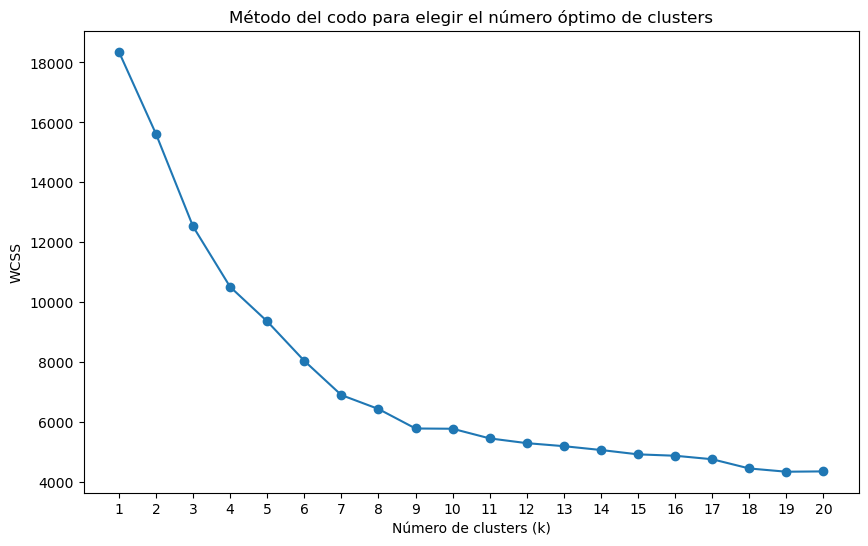

In [10]:
import matplotlib.pyplot as plt
from river import preprocessing, cluster
import math

# Lista para almacenar la inercia de cada valor de k
wcss_values = []
k_values = range(1, 21)  # Probar diferentes números de clusters, de 1 a 20

# Scaler
scaler = preprocessing.StandardScaler()

# Para cada valor de k
for k in k_values:
    # Inicializar el modelo KMeans con el valor de k
    kmeans = cluster.KMeans(n_clusters=k, seed=133)
    wcss = 0.0  # Variable para acumular la inercia para este k

    for index, row in df.iterrows():
        features = {
            'num_caracteres': float(row['num_caracteres']),
            'num_palabras': float(row['num_palabras']),
            'num_alfabeticos': float(row['num_alfabeticos']),
            'num_numericos': float(row['num_numericos']),
            'num_no_alfanum': float(row['num_no_alfanum']),
            'num_divisas': float(row['num_divisas']),
            'num_mayusculas': float(row['num_mayusculas']),
            'num_exclamaciones': float(row['num_exclamaciones']),
            'num_interrogaciones': float(row['num_interrogaciones']),
            'num_urls': float(row['num_urls'])
        }

        # Escalar las características
        scaler.learn_one(features)
        features_scaled = scaler.transform_one(features)

        # Predecir el cluster y aprender en cada iteración
        cluster_id = kmeans.predict_one(features_scaled)
        kmeans.learn_one(features_scaled)

        # Calcular la distancia cuadrada al centroide del cluster asignado
        centroids = kmeans.centers
        if centroids:
            centroid = centroids[cluster_id]
            distance_squared = sum((features_scaled[feature] - centroid[feature]) ** 2 for feature in features_scaled)
            wcss += distance_squared

    # Guardar la inercia para este valor de k
    wcss_values.append(wcss)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss_values, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('WCSS')
plt.title('Método del codo para elegir el número óptimo de clusters')
plt.xticks(range(int(min(k_values)), int(max(k_values)) + 1))
plt.show()

Con este método, no siempre queda totalmente claro qué cantidad de clusters seleccionar. Por ejemplo, en la gráfica generada hay dos puntos que podrían ser buenos candidatos: 4 y 7. Ambos son puntos donde el WCSS deja de descender tanto, aunque en este caso seleccionamos siete clusters, ya que la línea tiende a estabilizarse más después.

In [11]:
# Clustering con 7 clusters

from river import preprocessing, cluster
import math

scaler = preprocessing.StandardScaler()

kmeans = cluster.KMeans(n_clusters=7, seed=133)

### **Flujo de Datos para Detección de Anomalías**

En esta sección, simulamos el procesamiento en flujo continuo de datos (streaming) y escalamos las características y las agrupamos en clústeres utilizando KMeans. Detectaremos anomalías cuando la distancia al centroide sea mayor que el umbral definido.

In [37]:
import matplotlib.pyplot as plt
import math

threshold = 10.0

anomalies_detected = 0

indices_anomalias = []

cluster_counts = {}

def euclidean_distance(point, center):
    return math.sqrt(sum((point[feature] - center[feature]) ** 2 for feature in point))

for index, row in df.iterrows():
    features = {
        'num_caracteres': float(row['num_caracteres']),
        'num_palabras': float(row['num_palabras']),
        'num_alfabeticos': float(row['num_alfabeticos']),
        'num_numericos': float(row['num_numericos']),
        'num_no_alfanum': float(row['num_no_alfanum']),
        'num_divisas': float(row['num_divisas']),
        'num_mayusculas': float(row['num_mayusculas']),
        'num_exclamaciones': float(row['num_exclamaciones']),
        'num_interrogaciones': float(row['num_interrogaciones']),
        'num_urls': float(row['num_urls'])
    }

    scaler.learn_one(features)
    
    features_scaled = scaler.transform_one(features)

    cluster_id = kmeans.predict_one(features_scaled)

    centroids = kmeans.centers

    if centroids:
        centroid = centroids[cluster_id]

        distance_to_centroid = euclidean_distance(features_scaled, centroid)

        if distance_to_centroid > threshold:
            anomalies_detected += 1
            print(f"Anomalía detectada en {index} con distancia {distance_to_centroid:.2f} ")
            indices_anomalias.append(index)

    kmeans.learn_one(features_scaled)

    if cluster_id in cluster_counts:
        cluster_counts[cluster_id] += 1
    else:
        cluster_counts[cluster_id] = 1

print(f"Total de anomalías detectadas: {anomalies_detected}")
print("----------------------------------------------")

# Print cluster counts
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Clúster {cluster_id}: {count} datos")

Anomalía detectada en 793 con distancia 12.95 
Anomalía detectada en 1085 con distancia 25.66 
Anomalía detectada en 1579 con distancia 10.97 
Anomalía detectada en 1863 con distancia 10.16 
Anomalía detectada en 2158 con distancia 12.03 
Anomalía detectada en 2503 con distancia 18.90 
Anomalía detectada en 2676 con distancia 13.35 
Total de anomalías detectadas: 7
----------------------------------------------
Clúster 0: 244 datos
Clúster 1: 104 datos
Clúster 2: 1520 datos
Clúster 3: 1907 datos
Clúster 4: 928 datos
Clúster 5: 239 datos
Clúster 6: 632 datos


### **Observaciones**

Al aplicar KMeans para agrupar nuestros datos después de normalizarlos, pudimos identificar mensajes que se salen de lo común. Básicamente, calculamos la distancia de cada punto al centroide de su clúster y si esa distancia supera un cierto umbral (que fijamos en 10.0), consideramos que es una anomalía.

La normalización con StandardScaler fue clave aquí, ya que así nos aseguramos de que todas las características aporten por igual al cálculo de distancias. Si no lo hubiéramos hecho, algunas características podrían haber dominado el cálculo y las anomalías detectadas no serían representativas.

A continuación mostramos las filas que han sido detectadas como anomalías:

In [13]:
# Filas anómalas

df.loc[indices_anomalias, df.columns.difference(['text', 'spam'])]

,num_alfabeticos,num_caracteres,num_divisas,num_exclamaciones,num_interrogaciones,num_mayusculas,num_no_alfanum,num_numericos,num_palabras,num_urls
445,99,121,0,1,2,99,22,0,17,0
793,48,71,0,9,2,48,23,0,12,0
1085,718,910,0,0,0,12,192,0,171,0
1579,354,611,0,0,1,28,253,4,103,0
2158,403,588,0,5,1,53,183,2,125,0
2503,230,306,0,1,12,11,76,0,62,0
2676,85,136,0,11,1,6,51,0,30,0
2791,67,126,3,0,0,19,28,31,21,0


In [14]:
# Medias de cada columna en el dataset original

df.mean(numeric_only=True)

spam                    0.134015
num_caracteres         80.445282
num_palabras           15.591676
num_alfabeticos        59.114460
num_numericos           2.383387
num_no_alfanum         18.947435
num_divisas             0.063150
num_mayusculas          5.631324
num_exclamaciones       0.250628
num_interrogaciones     0.278615
num_urls                0.019017
dtype: float64

La observación más anómala es la 1085, que está a 25.61 unidades de distancia de su centroide. Esta fila se caracteriza por tener un elevadísimo número de caracteres, pues tiene 910 de ellos cuando la media del dataset es 80. Lo mismo ocurre con el número de palabras y el de caracteres alfabéticos.

Después está la fila 2503, a 18.91 unidades de distancia de su centroide. También esta fila tiene un elevado número de caracteres, aunque el valor más dispar es el número de interrogaciones, 12, cuando la media de interrogaciones por mensaje es menor de uno. Algo similar ocurre con las filas 793 y 2158. La fila 2676, sin embargo, destaca por su cantidad de exclamaciones, 11, que también la hacen alejarse de otros elementos de su cluster.

En conjunto, estas anomalías surgen al poseer en alguna variable un valor que dista mucho de los demás valores de esa variable. Por esto, al proyectar las observaciones en un espacio multidimensional, estos puntos se alejan significativamente más de sus respectivos centroides.

----------------------

## **Tratamiento de Texto**

En esta sección, compararemos dos técnicas para la extracción de características de texto:
- **Bag of Words (BOW)**: Simplemente cuenta las ocurrencias de cada palabra en el texto.
- **TF-IDF (Term Frequency-Inverse Document Frequency)**: Pondera la frecuencia de las palabras considerando también su relevancia en el conjunto total de datos.

Ambas técnicas serán combinadas con un clasificador Naive Bayes para evaluar cuál de las dos consigue mejores resultados en la clasificación de mensajes SPAM.

### **Bag of Words con Naive Bayes**

En este apartado implementamos la técnica de Bag of Words junto con el clasificador Naive Bayes. Entrenaremos el modelo y evaluaremos su rendimiento usando la métrica **F1 Score**.

In [15]:
from river import feature_extraction, naive_bayes, compose, metrics

bow = feature_extraction.BagOfWords(lowercase=True)

model_bayes = naive_bayes.MultinomialNB()

pipeline_BowNb = compose.Pipeline(('vectorizer', bow), ('nb', model_bayes))

metric = metrics.F1()

for index, row in df.iterrows():
    text = row['text']
    y = row['spam']
    
    y_pred = pipeline_BowNb.predict_one(text)
    
    metric.update(y, y_pred)
    
    pipeline_BowNb.learn_one(text, y)

print(f"F1 Score final con Bag of Words: {metric.get()}")


F1 Score final con Bag of Words: 0.9002590673575129


### **TF-IDF con Naive Bayes**

En esta parte, utilizamos la técnica de TF-IDF junto con el clasificador Naive Bayes. Evaluaremos su rendimiento en flujo de datos de la misma manera que lo hicimos con Bag of Words.

In [16]:
tfidf = feature_extraction.TFIDF(lowercase=True, ngram_range=(1,1))
model_bayes = naive_bayes.MultinomialNB()
pipeline_TFIDFNb = compose.Pipeline(('vectorizer', tfidf), ('TFI-IDF', model_bayes))

metric = metrics.F1()

for index, row in df.iterrows():
    text = row['text']
    y = row['spam']
    
    y_pred = pipeline_TFIDFNb.predict_one(text)
    
    metric.update(y, y_pred)
    
    pipeline_TFIDFNb.learn_one(text, y)

print(f"F1 Score final con TF-IDF: {metric.get()}")

F1 Score final con TF-IDF: 0.7392405063291139


### **Observaciones**

Al comparar Bag of Words y TF-IDF con un clasificador Naive Bayes para detectar SPAM, observamos que Bag of Words obtuvo un F1 Score de 0.9003, mientras que TF-IDF alcanzó un F1 Score de 0.7392.

Esto sugiere que, en nuestro caso, contar simplemente la frecuencia de las palabras es más efectivo que ponderarlas según su relevancia en el conjunto de datos. Bag of Words logró identificar mejor los mensajes de SPAM, posiblemente porque las palabras clave aparecen con mucha frecuencia en estos mensajes y no es necesario ajustar su peso.

--------

## **Ensembles**
Aplicamos el modelo AdaBoostingClassifier de la librería RIver sobre el clasificador que mejor resultado nos dio al inicio, el HOeffdingAdaptiveTreeClassifier.



In [17]:
from river import metrics, tree, ensemble

metric = metrics.F1()
model_adaptive = tree.HoeffdingAdaptiveTreeClassifier()
model_ensemble_AdaBoost = ensemble.AdaBoostClassifier(model=model_adaptive, n_models=5)

for index, row in df.iterrows():
    x = {
        'num_caracteres': row['num_caracteres'],
        'num_palabras': row['num_palabras'],
        'num_alfabeticos': row['num_alfabeticos'],
        'num_numericos': row['num_numericos'],
        'num_no_alfanum': row['num_no_alfanum'],
        'num_divisas': row['num_divisas'],
        'num_mayusculas': row['num_mayusculas'],
        'num_exclamaciones': row['num_exclamaciones'],
        'num_interrogaciones': row['num_interrogaciones'],
        'num_urls': row['num_urls']
    }

    y = row['spam']
    y_pred = model_ensemble_AdaBoost.predict_one(x)
    model_ensemble_AdaBoost.learn_one(x, y)
    metric.update(y, y_pred)

print(f"F1 Score final: {metric}")



F1 Score final: F1: 87.11%


Aplicamos el modelo ADWINBoostingClassifier de la librería RIver sobre el clasificador que mejor resultado nos dio al inicio, el HoeffdingAdaptiveTreeClassifier.

In [18]:
from river import metrics, tree, ensemble

metric = metrics.F1()
model_adaptive = tree.HoeffdingAdaptiveTreeClassifier()
model_ensemble_AdWINBoosting = ensemble.ADWINBoostingClassifier(model=model_adaptive, n_models=5)

for index, row in df.iterrows():
    x = {
        'num_caracteres': row['num_caracteres'],
        'num_palabras': row['num_palabras'],
        'num_alfabeticos': row['num_alfabeticos'],
        'num_numericos': row['num_numericos'],
        'num_no_alfanum': row['num_no_alfanum'],
        'num_divisas': row['num_divisas'],
        'num_mayusculas': row['num_mayusculas'],
        'num_exclamaciones': row['num_exclamaciones'],
        'num_interrogaciones': row['num_interrogaciones'],
        'num_urls': row['num_urls']
    }

    y = row['spam']
    y_pred = model_ensemble_AdWINBoosting.predict_one(x)
    model_ensemble_AdWINBoosting.learn_one(x, y)
    metric.update(y, y_pred)

print(f"F1 Score final: {metric}")


F1 Score final: F1: 87.64%


--------

## **Flujo de datos Simulado**

In [19]:
import time

try:
    for index, row in df.iterrows():
        X = {
            'text': row['text'],
            'num_caracteres': row['num_caracteres'],
            'num_palabras': row['num_palabras'],
            'num_alfabeticos': row['num_alfabeticos'],
            'num_numericos': row['num_numericos'],
            'num_no_alfanum': row['num_no_alfanum'],
            'num_divisas': row['num_divisas'],
            'num_mayusculas': row['num_mayusculas'],
            'num_exclamaciones': row['num_exclamaciones'],
            'num_interrogaciones': row['num_interrogaciones'],
            'num_urls': row['num_urls']
        }

        y = row['spam'] 
        
        print(f"Datos recibidos: {X}, Etiqueta: {y}")
        
        time.sleep(0.5)
        
except KeyboardInterrupt:
    print('Proceso detenido por el usuario.')

Datos recibidos: {'text': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'num_caracteres': 111, 'num_palabras': 20, 'num_alfabeticos': 83, 'num_numericos': 0, 'num_no_alfanum': 28, 'num_divisas': 0, 'num_mayusculas': 3, 'num_exclamaciones': 0, 'num_interrogaciones': 0, 'num_urls': 0}, Etiqueta: 0
Datos recibidos: {'text': 'Ok lar... Joking wif u oni...', 'num_caracteres': 29, 'num_palabras': 6, 'num_alfabeticos': 18, 'num_numericos': 0, 'num_no_alfanum': 11, 'num_divisas': 0, 'num_mayusculas': 2, 'num_exclamaciones': 0, 'num_interrogaciones': 0, 'num_urls': 0}, Etiqueta: 0
Datos recibidos: {'text': "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'num_caracteres': 155, 'num_palabras': 28, 'num_alfabeticos': 97, 'num_numericos': 25, 'num_no_alfanum': 33, 'num_divisas': 0, 'num_mayusculas': 10, 'num_exclamaciones